In [1]:
import pymysql
import pandas as pd
import numpy as np
import datetime
from sklearn import preprocessing
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
import gc
import sys
sys.path.append(r'D:\jupyter files\waiting_time_project\my_tools')
import tools_for_os.for_df as ml_df
import tools_for_os.for_file as ml_fl

In [2]:
data_path = 'D:\\jupyter files\\data_waiting_time_project\\preprocess_data\\'
lightgbm_data_path = data_path + 'lightgbm_data\\'

ml_fl.create_folder(lightgbm_data_path)

D:\jupyter files\data_waiting_time_project\preprocess_data\lightgbm_data\ already existed!


In [3]:
def RMSE(pred_y, test_y):
    sq = sum((pred_y - test_y)**2) / len(pred_y)
#     sq = sum((pred_y - np.array(test_y.Actual_duration.tolist()))**2) / len(pred_y)
    rmse = np.sqrt(sq)
    return rmse

In [4]:
def MAE(pred_y, test_y):
    mae = sum(np.abs((pred_y - test_y))) / len(pred_y)
    return mae

In [5]:
feature_num = ['Scheduled_duration', 'Actual_duration',
               'age', 'TreatmentTime_total', 'ImagesTaken_total',
               'MU_total', 'MUCoeff_total']

# RadiationId
feature_cate = ['dxt_AliasName', 'Sex', 'AliasSerNum',
                'month', 'week', 'hour', 'DoctorSerNum', 
                'TreatmentOrientation', 'FractionNumber',
                'UserName', 'CourseId', 'ResourceSerNum']

# 加载数据
预处理后的数据，可以直接使用<br>
但是数据保存在CSV 之后，会按照CSV 的格式来储存和加载数据，因此，就算保存前已经把一些分类变量编码后的结果转成了“category”类型，但是在CSV 中仍然变成了float 或int 类型

In [73]:
print('='*40)
print('Load data')
data_display = pd.read_csv(lightgbm_data_path + 'data_display.csv', index_col=0)
data_display = data_display.sample(frac = 1, random_state = 1)
data_display.reset_index(drop = True, inplace = True)

data = pd.read_csv(lightgbm_data_path + 'data.csv', index_col=0)
train_x = pd.read_csv(lightgbm_data_path + 'train_x.csv', index_col=0)
train_y = pd.read_csv(lightgbm_data_path + 'train_y.csv', index_col=0)
test_x = pd.read_csv(lightgbm_data_path + 'test_x.csv', index_col=0)
test_y = pd.read_csv(lightgbm_data_path + 'test_y.csv', index_col=0)


# date 这一特征不具有价值，因为未来的预测不可能出现相同的date
# 这个可以考虑改成day，每月几号
data_display.drop('date', axis = 1, inplace = True)
data_display.drop('RadiationId', axis = 1, inplace = True)

train_x.drop('date', axis = 1, inplace = True)
train_x.drop('RadiationId', axis = 1, inplace = True)
test_x.drop('date', axis = 1, inplace = True)
test_x.drop('RadiationId', axis = 1, inplace = True)


train_x_display = data_display.loc[train_x.index]
test_x_display = data_display.loc[test_x.index]


# 筛选样本
print(f'The shape of train_y is {train_y.shape}')
train_y = train_y[(train_y.Actual_duration >= 10) &
                  (train_y.Actual_duration <= 60)]
train_x = train_x.loc[train_y.index]
train_x_display = train_x_display.loc[train_y.index]
print(f'The shape of train_y is {train_y.shape}')


print(f'\nThe shape of test_y is {test_y.shape}')
test_y = test_y[(test_y.Actual_duration >= 10) &
                (test_y.Actual_duration <= 60)]
test_x = test_x.loc[test_y.index]
test_x_display = test_x_display.loc[test_y.index]
print(f'The shape of test_y is {test_y.shape}')

Load data
The shape of train_y is (547461, 1)
The shape of train_y is (498219, 1)

The shape of test_y is (60830, 1)
The shape of test_y is (55288, 1)


In [74]:
train_x = ml_df.fill_nan(train_x, feature_num, 'number')
train_x = ml_df.fill_nan(train_x, feature_cate, 'cate')
train_x = ml_df.cate_type(train_x, feature_cate)
train_x = train_x.sample(frac = 1, random_state = 1)
train_y = train_y.sample(frac = 1, random_state = 1)

test_x = ml_df.fill_nan(test_x, feature_num, 'number')
test_x = ml_df.fill_nan(test_x, feature_cate, 'cate')
test_x = ml_df.cate_type(test_x, feature_cate)
test_x = test_x.sample(frac = 1, random_state = 1)
test_y = test_y.sample(frac = 1, random_state = 1)


# 以下是专门为shap 准备的原数据，方便画图
train_x_display = ml_df.fill_nan(train_x_display, feature_num, 'number')
train_x_display = ml_df.fill_nan(train_x_display, feature_cate, 'cate')
train_x_display = ml_df.cate_type(train_x_display, feature_cate)
train_x_display = train_x_display.sample(frac = 1, random_state = 1)
train_x_display.drop('Actual_duration', axis = 1, inplace = True)

test_x_display = ml_df.fill_nan(test_x_display, feature_num, 'number')
test_x_display = ml_df.fill_nan(test_x_display, feature_cate, 'cate')
test_x_display = ml_df.cate_type(test_x_display, feature_cate)
test_x_display = test_x_display.sample(frac = 1, random_state = 1)
test_x_display.drop('Actual_duration', axis = 1, inplace = True)

# 人工基准

In [8]:
# 测试
pred_y = test_x.Scheduled_duration.tolist()

mae = MAE(np.array(pred_y), np.array(test_y.Actual_duration.tolist()))
print(mae)

7.230447836781942


# 模型
损失函数选择mae 更好一点，rmse 和mse 可能会存在过拟合问题，测试结果的误差都比较大

In [9]:
# model_path = 'D:\\jupyter files\\data_waiting_time_project\\model\\'
 
# # 模型保存
# gbm.booster_.save_model(model_path + 'gbm.txt')
 
# # # 模型加载
# # gbm = lgb.Booster(model_file = model_path + 'gbm.txt')

In [10]:
# # 创建模型，训练模型
# print('='*40)
# print('Train model')
# gbm = lgb.LGBMRegressor(objective='mae', num_leaves=15, learning_rate=0.1,
#                         n_estimators = 20000)#num_leaves=31
# gbm.fit(
#     train_x[: int(train_x.shape[0] * 0.9)], train_y[: int(train_y.shape[0] * 0.9)],
#     eval_set=[(train_x[int(train_x.shape[0] * 0.9):], train_y[int(train_y.shape[0] * 0.9):])],
#     eval_metric='mae',
#     early_stopping_rounds=100,
#     verbose=200
# )


In [11]:
# # 测试
# pred_y = gbm.predict(test_x, num_iteration = gbm.best_iteration_)

# mae = MAE(pred_y, np.array(test_y.Actual_duration.tolist()))
# print(mae)
# # 3.9896504475601353

In [12]:
# 创建模型，训练模型
print('='*40)
print('Train model')
gbm1 = lgb.LGBMRegressor(objective='mae', num_leaves=31, learning_rate=0.1,
                        n_estimators = 20000)#num_leaves=31
gbm1.fit(
    train_x[: int(train_x.shape[0] * 0.9)], train_y[: int(train_y.shape[0] * 0.9)],
    eval_set=[(train_x[int(train_x.shape[0] * 0.9):], train_y[int(train_y.shape[0] * 0.9):])],
    eval_metric='mae',
    early_stopping_rounds=100,
    verbose=200
)

Train model
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 4.76229
[400]	valid_0's l1: 4.56312
[600]	valid_0's l1: 4.43261
[800]	valid_0's l1: 4.35445
[1000]	valid_0's l1: 4.28787
[1200]	valid_0's l1: 4.22373
[1400]	valid_0's l1: 4.18859
[1600]	valid_0's l1: 4.14585
[1800]	valid_0's l1: 4.11318
[2000]	valid_0's l1: 4.06697
[2200]	valid_0's l1: 4.03761
[2400]	valid_0's l1: 4.00105
[2600]	valid_0's l1: 3.97884
[2800]	valid_0's l1: 3.95438
[3000]	valid_0's l1: 3.93479
[3200]	valid_0's l1: 3.90826
[3400]	valid_0's l1: 3.88552
[3600]	valid_0's l1: 3.85945
[3800]	valid_0's l1: 3.83315
[4000]	valid_0's l1: 3.81035
[4200]	valid_0's l1: 3.79029
[4400]	valid_0's l1: 3.77112
[4600]	valid_0's l1: 3.75543
[4800]	valid_0's l1: 3.73134
[5000]	valid_0's l1: 3.70367
[5200]	valid_0's l1: 3.68544
[5400]	valid_0's l1: 3.66825
[5600]	valid_0's l1: 3.64679
[5800]	valid_0's l1: 3.62923
[6000]	valid_0's l1: 3.61297
[6200]	valid_0's l1: 3.59814
[6400]	valid_0's l1: 3.5829
[66

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=20000, n_jobs=-1, num_leaves=31, objective='mae',
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [13]:
# 测试
pred_y = gbm1.predict(test_x, num_iteration = gbm1.best_iteration_)

mae = MAE(pred_y, np.array(test_y.Actual_duration.tolist()))
print(mae)
# 3.557135519729081

3.000852984032997


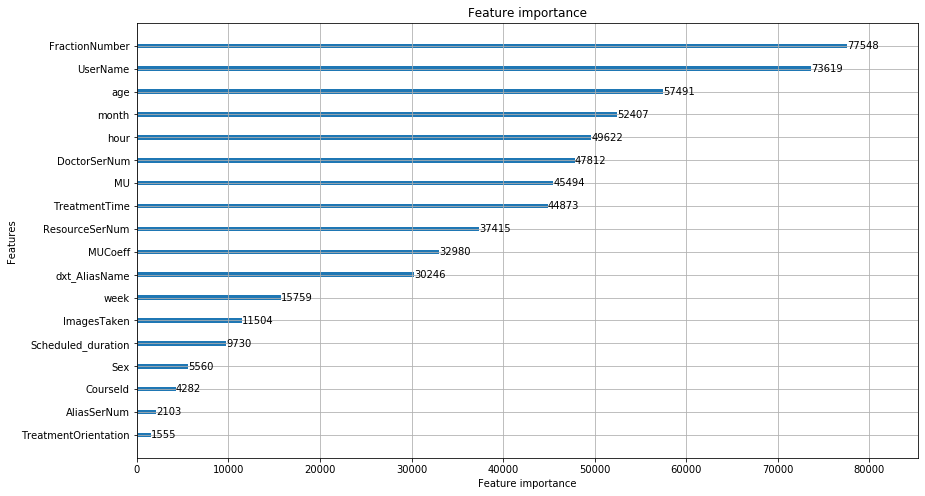

In [14]:
fig, ax = plt.subplots(figsize=(14, 8))
lgb.plot_importance(gbm1.booster_, max_num_features=19, ax=ax)

##### 使用RMSE 作为损失函数，预测准确率有所降低

In [15]:
# # 创建模型，训练模型
# print('='*40)
# print('Train model')
# gbm_loss = lgb.LGBMRegressor(objective='mse', num_leaves=31, learning_rate=0.05,
#                         n_estimators = 20000)
# gbm_loss.fit(
#     train_x[: int(train_x.shape[0] * 0.9)], train_y[: int(train_y.shape[0] * 0.9)],
#     eval_set=[(train_x[int(train_x.shape[0] * 0.9):], train_y[int(train_y.shape[0] * 0.9):])],
#     eval_metric='mse',
#     early_stopping_rounds=100,
#     verbose=200
# )

In [16]:
# # 测试
# pred_y = gbm_loss.predict(test_x, num_iteration = gbm_loss.best_iteration_)

# mae = MAE(pred_y, np.array(test_y.Actual_duration.tolist()))
# print(mae)
# # 2.9573814580644577

In [17]:
# # 测试
# pred_y = gbm_loss.predict(test_x, num_iteration = gbm_loss.best_iteration_)

# rmse = RMSE(pred_y, np.array(test_y.Actual_duration.tolist()))
# print(rmse)
# # 4.2132583126025445

# # MSE 10.6361
# # 如果使用mae来进行测试集的评价2.9573814580644577
# # 还需要进一步检查一下

##### 不加入医生的预测

In [77]:
data_display_ = data_display.copy()
data_ = data.copy()
train_x_ = train_x.copy()
train_y_ = train_y.copy()
test_x_ = test_x.copy()
test_y_ = test_y.copy()

In [78]:
train_x_.drop(['Scheduled_duration'], axis = 1, inplace = True)
test_x_.drop(['Scheduled_duration'], axis = 1, inplace = True)

In [20]:
# 创建模型，训练模型
print('='*40)
print('Train model')
gbm_sch = lgb.LGBMRegressor(objective='mae', num_leaves=31, learning_rate=0.1,
                        n_estimators = 20000)#num_leaves=31

gbm_sch.fit(
    train_x_[: int(train_x_.shape[0] * 0.9)], train_y_[: int(train_y_.shape[0] * 0.9)],
    eval_set=[(train_x_[int(train_x_.shape[0] * 0.9):], train_y_[int(train_y_.shape[0] * 0.9):])],
    eval_metric='mae',
    early_stopping_rounds=100,
    verbose=200
)


Train model
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 5.111
[400]	valid_0's l1: 4.86682
[600]	valid_0's l1: 4.74434
[800]	valid_0's l1: 4.64589
[1000]	valid_0's l1: 4.5672
[1200]	valid_0's l1: 4.50922
[1400]	valid_0's l1: 4.46339
[1600]	valid_0's l1: 4.40328
[1800]	valid_0's l1: 4.35131
[2000]	valid_0's l1: 4.29696
[2200]	valid_0's l1: 4.25256
[2400]	valid_0's l1: 4.20995
[2600]	valid_0's l1: 4.17996
[2800]	valid_0's l1: 4.15601
[3000]	valid_0's l1: 4.13192
[3200]	valid_0's l1: 4.09863
[3400]	valid_0's l1: 4.07468
[3600]	valid_0's l1: 4.04605
[3800]	valid_0's l1: 4.01296
[4000]	valid_0's l1: 3.99254
[4200]	valid_0's l1: 3.96229
[4400]	valid_0's l1: 3.93282
[4600]	valid_0's l1: 3.9026
[4800]	valid_0's l1: 3.87644
[5000]	valid_0's l1: 3.85875
[5200]	valid_0's l1: 3.83947
[5400]	valid_0's l1: 3.82213
[5600]	valid_0's l1: 3.80442
[5800]	valid_0's l1: 3.78899
[6000]	valid_0's l1: 3.7759
[6200]	valid_0's l1: 3.76042
[6400]	valid_0's l1: 3.74411
[6600]	

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=20000, n_jobs=-1, num_leaves=31, objective='mae',
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [21]:
# 测试
pred_y_ = gbm_sch.predict(test_x_, num_iteration = gbm_sch.best_iteration_)

mae = MAE(pred_y_, np.array(test_y_.Actual_duration.tolist()))
print(mae)
# 4.382373629007738

3.1534836224035825


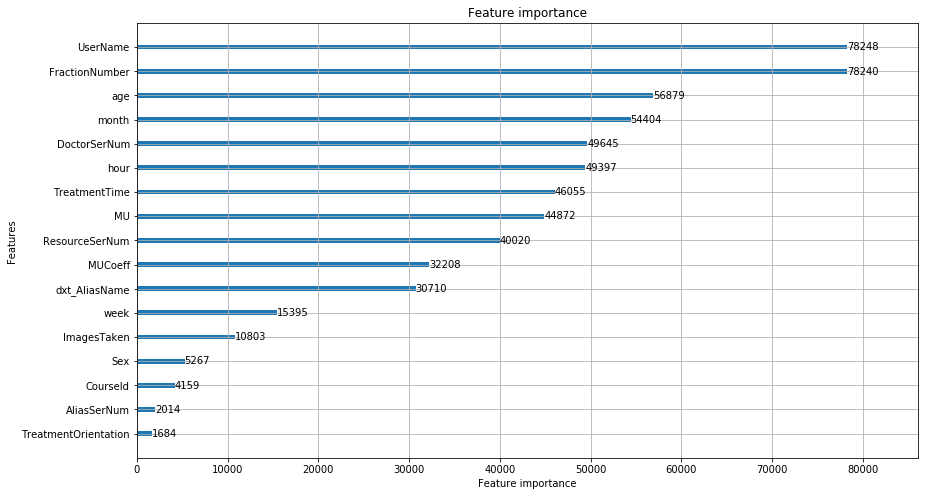

In [22]:
fig, ax = plt.subplots(figsize=(14, 8))
lgb.plot_importance(gbm_sch.booster_, max_num_features=18, ax = ax)

# shap

In [23]:
# print the JS visualization code to the notebook
shap.initjs()

##### 先将数据格式改变，这样后面能够正常显示分类变量

In [75]:
# # 仍然出现报错，无法使用
# feature_cate = ['dxt_AliasName', 'Sex', 'AliasSerNum', 
#                 'month', 'week', 'hour', 'date','DoctorSerNum', 
#                 'TreatmentOrientation', 'FractionNumber',
#                 'UserName', 'RadiationId', 'CourseId', 'ResourceSerNum']

# for col in feature_cate:
#     try:
#         data_train_display[col] = data_train_display.astype('category')
#         train_x[col] = train_x.astype(int)
#     except:
#         print(f'no column: {col}')

In [76]:
# # 对于分类变量，需要显示原始变量值的话，就需要加载display
# data_train_display = data_display[: int(data.shape[0] * 0.9)]
# data_val_display = data_train_display[int(train_x.shape[0] * 0.9): ]
# data_val_display.drop('Actual_duration', axis = 1, inplace = True)
# data_val_display.reset_index(drop = True, inplace = True)

In [79]:
data_val_x = train_x[int(train_x.shape[0] * 0.9): ]
data_val_y = train_y[int(train_y.shape[0] * 0.9): ]

data_val_x_display = train_x_display[int(train_x_.shape[0] * 0.9): ]


data_val_x_sch = train_x_[int(train_x_.shape[0] * 0.9): ]
data_val_y_sch = train_y_[int(train_y_.shape[0] * 0.9): ]

data_val_x_display_sch = train_x_display[int(train_x_.shape[0] * 0.9): ]
data_val_x_display_sch.drop('Scheduled_duration', axis = 1, inplace = True)

In [27]:
explainer = shap.TreeExplainer(gbm1.booster_)
shap_values = explainer.shap_values(data_val_x[: 1000])

explainer_sch = shap.TreeExplainer(gbm_sch.booster_)
shap_values_sch = explainer_sch.shap_values(data_val_x_sch[: 1000])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [28]:
# 得到分类变量编码后的字典
def get_label_dic(data_val, col):
    # 关于concat 为什么ignore_index 不能用 https://segmentfault.com/a/1190000015370825
    feature_label = data_val[[col]].reset_index(drop = True, inplace = False)
    feature_value = data_val_display[[col]].reset_index(drop = True, inplace = False)

    features_name = pd.concat([feature_label, feature_value], ignore_index = False, axis = 1)
    features_name.drop_duplicates(inplace = True)
    features_name.reset_index(drop = True, inplace = True)
    return features_name

In [31]:
# get_label_dic(data_val_x, 'Sex')

=====================================================
#### 一个样本

这是对于一个样本，每个特征的贡献程度。
以该样本为例，该样本的实际治疗时长为21.00min，模型给出的预测值为12.97min。
其中，age 和MU 这两个因素对于结果的贡献为正，其他特征对于结果的贡献为负，负贡献的特征，最主要的是Scheduled_duration、FractionNumber、dxt_AliasSerName和AliasSerNum。
从shapley value 的取值，我们可以看到每个特征具体的边际贡献值。
通过shap 对模型的归因，我们可以向每一位患者提供一些关于预期治疗时长的影响因素，从而缓解患者治疗时长不确定造成的紧张压力，同时因为患者的等待时长中，很大一部分的来源是序列中排前的患者的预期治疗时长，这些患者的预测归因，能够向排队患者提供等待时长的来源，比如因为前排患者大部分是高龄，女性，需要拍摄大量X 光片等。

In [32]:
data_val_y.iloc[1]

Actual_duration    25.0
Name: 77932, dtype: float64

In [93]:
data_val_y_sch.iloc[1]

Actual_duration    25.0
Name: 77932, dtype: float64

In [33]:
data_val_x.iloc[1]

Scheduled_duration             30
age                            63
TreatmentTime           0.0923068
ImagesTaken                     0
MU                        56.3883
MUCoeff                   33.6955
dxt_AliasName                 0.0
Sex                           0.0
AliasSerNum                   0.0
month                         0.0
week                          3.0
hour                          9.0
DoctorSerNum                 17.0
TreatmentOrientation          7.0
FractionNumber                4.0
UserName                     80.0
CourseId                      1.0
ResourceSerNum                4.0
Name: 77932, dtype: object

In [94]:
data_val_x_sch.iloc[1]

age                            63
TreatmentTime           0.0923068
ImagesTaken                     0
MU                        56.3883
MUCoeff                   33.6955
dxt_AliasName                 0.0
Sex                           0.0
AliasSerNum                   0.0
month                         0.0
week                          3.0
hour                          9.0
DoctorSerNum                 17.0
TreatmentOrientation          7.0
FractionNumber                4.0
UserName                     80.0
CourseId                      1.0
ResourceSerNum                4.0
Name: 77932, dtype: object

In [34]:
shap_values[1]

array([ 5.12842109, -0.27988592,  0.16190761, -0.42248712, -0.1341555 ,
        0.84234568,  0.5343099 ,  0.20923428, -0.31619202, -0.24823457,
       -0.47702555, -0.11729276,  0.29538614, -0.01738176, -1.82451081,
       -0.47535201,  0.01096044,  0.28375743])

In [81]:
f = plt.gcf()

f = shap.force_plot(
    explainer.expected_value, 
    shap_values[1], 
    data_val_x.iloc[1]
)
# data_val_display.iloc[1]

f

<Figure size 432x288 with 0 Axes>

In [95]:
f = plt.gcf()

f = shap.force_plot(
    explainer_sch.expected_value, 
    shap_values_sch[1], 
    data_val_x_sch.iloc[1]
)
# data_val_display.iloc[1]

f

<Figure size 432x288 with 0 Axes>

In [97]:
# pic_path = 'D:\\waiting time\\毕业设计\\中文报告\\论文图片\\'
# f.savefig(pic_path + '一个样本_force_plot_sch.png')

In [86]:
shap.force_plot(
    explainer.expected_value, 
    shap_values[: 1000], 
    data_val_x[: 1000])

In [98]:
shap.force_plot(
    explainer_sch.expected_value, 
    shap_values_sch[: 1000], 
    data_val_x_sch[: 1000])

密度散点图画出了所有样本的情况。纵向的特征的排序是按照shapley value的平均绝对值，也就是特征对于预测的贡献，贡献越大的特征，也就是更重要的特征。横轴表示具体的特征取值对于预测结果的贡献。
红色表示特征的取值更高，蓝色表示特征的取值更低。对于数值变量，我们可以从图像上直观地理解它们的含义。比如Scheduled_duration 越大，那么预测的Acutal_duration 则也倾向于更大。对于分类变量，由于我们已经进行了编码，所以图中的大小并没有数值意义上的大小含义，我们需要通过编码的字典来查找其对应的特征值。比如对于Sex，图中可见，Sex 的值越小，其对于预测值越大，反之则越小。如果对应Sex 的字典

index |特征编码|特征值 
-|-|-
0|0.0|Female
1|1.0|Male
2|2.0|Unknown

说明，如果Sex的信息未知，对预测结果有更大的负向影响，如果Sex 为女性，那么对预测结果有更大的正向影响，如果是男性，则对于影响并不显著。

每一个特征密度线的宽度表示密度。如果特征在某个点取值很多，那么密度线就会更宽。以Scheduled_duration为例，在我们全部的样本中，大量的样本人为的预期治疗时长都是15min，因此可以推断密度线中，非常宽的地方取值近似为15min，图中可以看出，15min的取值对于大部分预测贡献较小，且多为负向的作用；Scheduled_duration 对于预测贡献显著的样本，其取值多为15min 以上。这一结果也可以说明，为什么在去掉Scheduled_duration 这一特征后，我们的预测结果仅有较小程度的下降。

对于整体模型重要因素的分析，可以帮助医生更加清楚什么类型的患者可能会有更长的治疗时长，比如女性、高龄；通知更加清楚哪些环节造成治疗时长更长，比如X 光片的拍摄，更大剂量的放射治疗。同时有些非医疗环节的因素，同样会对治疗时长产生影响，比如治疗进行在上半年的月份，时长倾向于更短；发生在下半年，时长可能更长，可能这些非医疗因素，会对于某些操作、或者医患的状态造成影响，比如蒙特利尔所处纬度较高，寒冷的天气在下半年出现地较早，且持续时间长，寒冷的气候可能让患者适应治疗的时长变长，更厚重的衣物可能让医生的操作变慢，这些因素都需要更多维度的数据做进一步的挖掘。

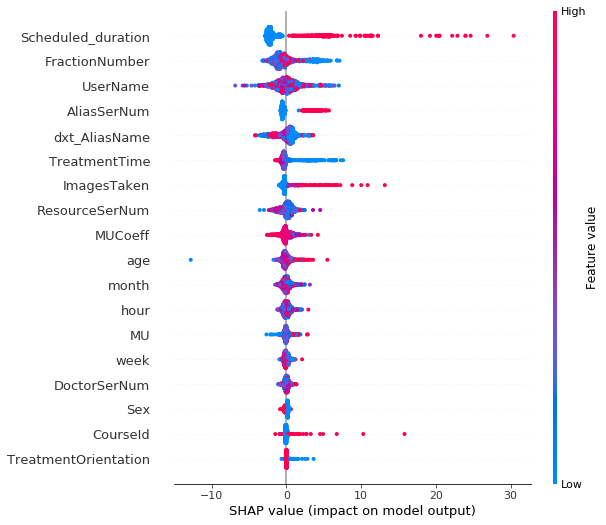

In [87]:
# summarize the effects of all the features
shap.summary_plot(shap_values, data_val_x[: 1000])

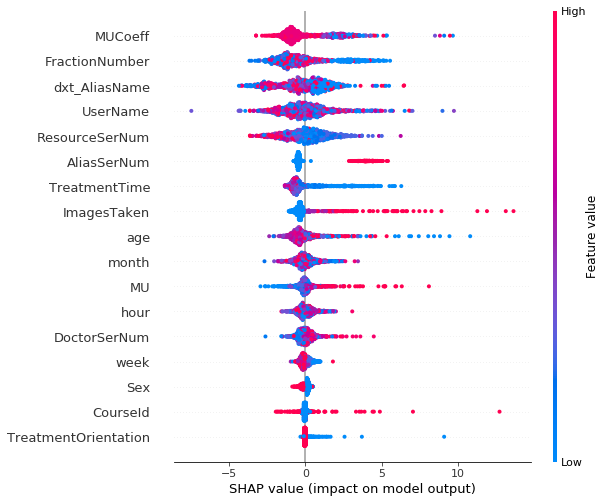

In [99]:
# summarize the effects of all the features
shap.summary_plot(shap_values_sch, data_val_x_sch[: 1000])

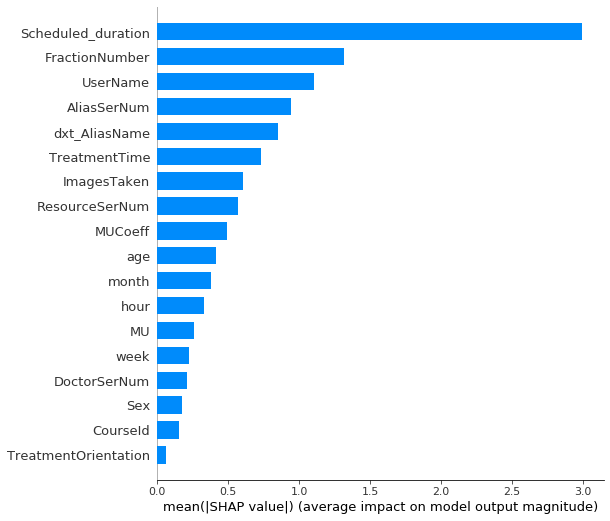

In [88]:
# summarize the effects of all the features
shap.summary_plot(shap_values, data_val_x[: 1000], plot_type = 'bar')

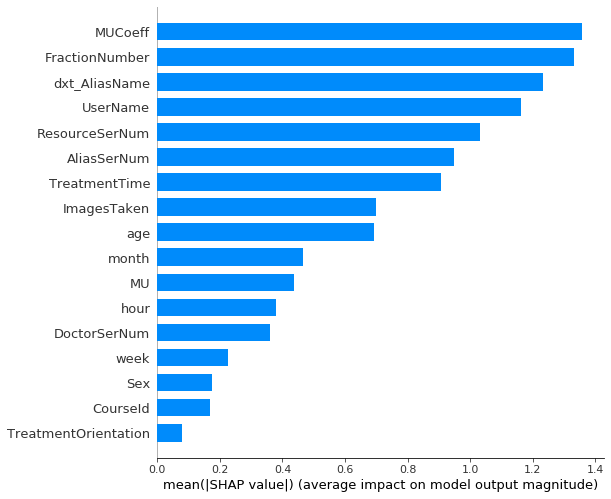

In [100]:
# summarize the effects of all the features
shap.summary_plot(shap_values_sch, data_val_x_sch[: 1000], plot_type = 'bar')

In [101]:
# shap.dependence_plot(
#     'Sex', 
#     shap_values, 
#     data_val_x[: 1000])

In [102]:
# for col in data_val_x.columns:
#     print(f'feature dependence_plot: {col}')
#     shap.dependence_plot(
#         col, 
#         shap_values, 
#         data_val_x[: 1000])
#     # display_features=X_display

==============================================================

In [48]:
import matplotlib.pyplot as plt

In [50]:
test_y.head()

,Actual_duration
557290,40.0
602616,19.0
555099,38.0
604198,11.0
579456,25.0


In [51]:
test_x.head()

,Scheduled_duration,age,TreatmentTime,ImagesTaken,MU,MUCoeff,dxt_AliasName,Sex,AliasSerNum,month,week,hour,DoctorSerNum,TreatmentOrientation,FractionNumber,UserName,CourseId,ResourceSerNum
557290,15.0,47,0.176893,2,107.156,82.5369,14.0,0.0,1.0,8.0,4.0,9.0,25.0,7.0,0.0,41.0,1.0,6.0
602616,15.0,45,0.228165,1,136.896,100.0000,1.0,0.0,0.0,11.0,1.0,8.0,2.0,7.0,2.0,98.0,1.0,2.0
555099,45.0,17,0.179793,0,142.770,100.0000,7.0,0.0,0.0,1.0,3.0,2.0,9.0,7.0,41.0,88.0,1.0,5.0
604198,15.0,51,0.168767,0,101.613,112.9010,1.0,1.0,0.0,8.0,3.0,9.0,2.0,7.0,12.0,43.0,1.0,4.0
579456,15.0,86,0.004667,0,133.042,92.5667,0.0,0.0,0.0,7.0,1.0,6.0,2.0,7.0,39.0,80.0,1.0,11.0


In [207]:
plot_data = pd.DataFrame({'Actual_duration': test_y.Actual_duration.tolist(),
                          'Scheduled_duration': test_x.Scheduled_duration.tolist(),
                          'pred_y': pred_y})
plot_data.sort_values(by = ['Actual_duration', 'Scheduled_duration', 'pred_y'], inplace = True)

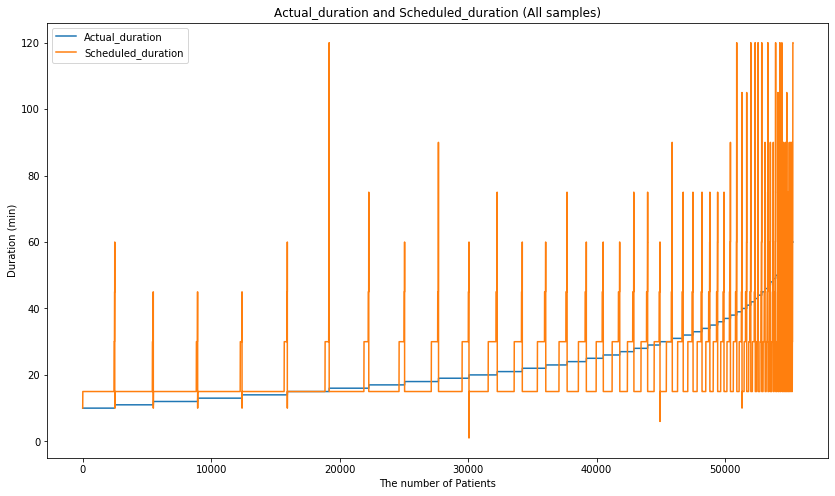

In [218]:
plot_data.sort_values(by = ['Actual_duration', 'Scheduled_duration'], inplace = True)
fig = plt.figure(figsize = (14, 8))
ax = plt.subplot(111)
x = range(len(pred_y))
y1 = plot_data.Actual_duration.tolist()
y2 = plot_data.Scheduled_duration.tolist()
y3 = plot_data.pred_y.tolist()
ax.plot(x, y1, label = 'Actual_duration')
ax.plot(x, y2, label = 'Scheduled_duration')
# ax.plot(x, y3, label = 'pred_y')
ax.set_xlabel('The number of Patients')
ax.set_ylabel('Duration (min)')
ax.set_title('Actual_duration and Scheduled_duration (All samples)')
ax.legend()
plt.show()

plot_data (55288, 4)
plot_data (22910, 4)



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


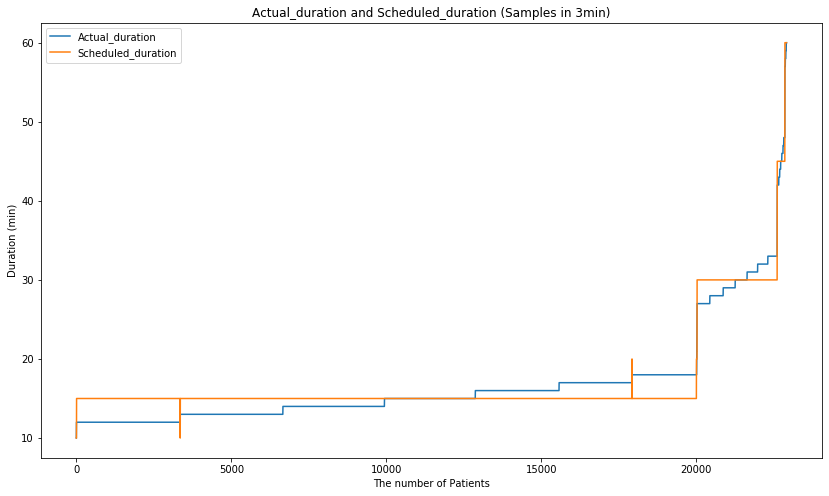

In [221]:
plot_data['mae_sch'] = np.abs(plot_data.Actual_duration - plot_data.Scheduled_duration)
print(f'plot_data {plot_data.shape}')
plot_data_ = plot_data[plot_data.mae_sch <= 3]
print(f'plot_data {plot_data_.shape}')
plot_data_.sort_values(by = ['Actual_duration', 'Scheduled_duration'], inplace = True)
fig = plt.figure(figsize = (14, 8))
ax = plt.subplot(111)
x = range(plot_data_.shape[0])
y1 = plot_data_.Actual_duration.tolist()
y2 = plot_data_.Scheduled_duration.tolist()
y3 = plot_data_.pred_y.tolist()
ax.plot(x, y1, label = 'Actual_duration')
ax.plot(x, y2, label = 'Scheduled_duration')# linestyle=':'
# ax.plot(x, y3, label = 'pred_y')
ax.set_xlabel('The number of Patients')
ax.set_ylabel('Duration (min)')
ax.set_title('Actual_duration and Scheduled_duration (Samples in 3min)')
ax.legend()
plt.show()

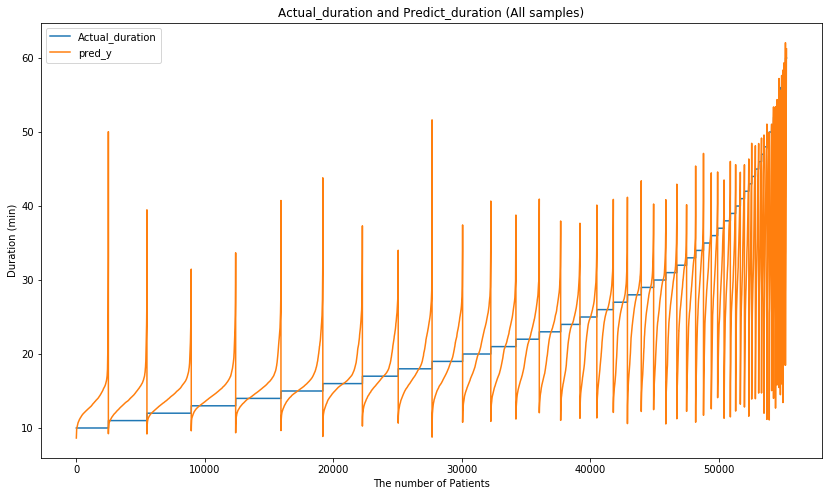

In [220]:
plot_data.sort_values(by = ['Actual_duration', 'pred_y'], inplace = True)
fig = plt.figure(figsize = (14, 8))
ax = plt.subplot(111)
x = range(len(pred_y))
y1 = plot_data.Actual_duration.tolist()
y2 = plot_data.Scheduled_duration.tolist()
y3 = plot_data.pred_y.tolist()
ax.plot(x, y1, label = 'Actual_duration')
# ax.plot(x, y2, label = 'Scheduled_duration')
ax.plot(x, y3, label = 'pred_y')
ax.set_xlabel('The number of Patients')
ax.set_ylabel('Duration (min)')
ax.set_title('Actual_duration and Predict_duration (All samples)')
ax.legend()
plt.show()

计算测试集中每一个样本的mae，我们可以更细致地观察我们的预测结果。样本中最大的mae为44.56min，其中mae在5min以内的样本占比为0.7348。
从可视化的结果，可以直观地看出，预测值在真实值的两侧波动，少量数据会有显著的异常差异，这部分数据可能导致我们最终的mae偏大。
在删除mae>5min之后的样本之后，可以看出我们的模型较好地捕捉到了治疗时长变化的趋势。

我们在筛选样本的时候比较粗略，实际情况中的治疗时长异常值无法被完全剔除，同时样本中可能存在信息覆盖的问题，mae过大的数据可能来源于异常样本。

在只保留mae 在3min 以内的样本，可视化的结果可以看出，模型捕捉到了治疗时长的变化趋势。对比医生预测的Scheduled_duration，同样在保留mae 在5min 以内的样本，从可视化后的结果看出，医生的预测，更倾向于给大多数患者一个平均治疗时长的预测，这种预测忽略了很多特殊原因导致治疗时长较长的患者。总体而言，医生的预测并没有真正捕捉到治疗时长的变化趋势，而序列中治疗时长较长的患者，就会造成后续患者等待时长的严重不准确，所以可能造成患者的紧张不安，增加对于医疗服务系统的不满。

In [64]:
plot_data.mae.max()

44.55959159187767

In [240]:
# 误差样本比例
print('Scheduled_duration')
plot_data['mae_sch'] = np.abs(plot_data.Actual_duration - plot_data.Scheduled_duration)
print(f'plot_data {plot_data.shape}')
# plot_data_ = plot_data[plot_data.mae_sch <= 3]
# print(f'plot_data {plot_data_.shape}')
# print(f'precent {plot_data_.shape[0] / plot_data.shape[0]}')

# plot_data_ = plot_data[plot_data.mae_sch <= 10]
# print(f'plot_data {plot_data_.shape}')
# print(f'precent {plot_data_.shape[0] / plot_data.shape[0]}')

plot_data_ = plot_data[plot_data.mae_sch <= 15]
print(f'plot_data {plot_data_.shape}')
print(f'precent {plot_data_.shape[0] / plot_data.shape[0]}')

print('\npred_y')
plot_data['mae'] = np.abs(plot_data.Actual_duration - plot_data.pred_y)
print(f'plot_data {plot_data.shape}')
# plot_data_ = plot_data[plot_data.mae <= 3]
# print(f'plot_data {plot_data_.shape}')
# print(f'precent {plot_data_.shape[0] / plot_data.shape[0]}')

# plot_data_ = plot_data[plot_data.mae <= 10]
# print(f'plot_data {plot_data_.shape}')
# print(f'precent {plot_data_.shape[0] / plot_data.shape[0]}')


plot_data_ = plot_data[plot_data.mae <= 15]
print(f'plot_data {plot_data_.shape}')
print(f'precent {plot_data_.shape[0] / plot_data.shape[0]}')

Scheduled_duration
plot_data (55288, 5)
plot_data (48339, 5)
precent 0.8743126899146288

pred_y
plot_data (55288, 5)
plot_data (53029, 5)
precent 0.9591412241354362


Scheduled_duration

pred_y


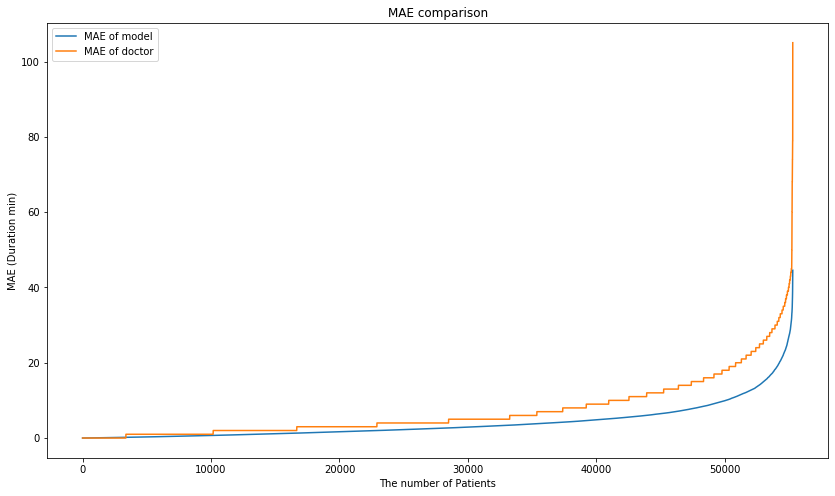

In [239]:
# 误差样本比例
print('Scheduled_duration')
plot_data['mae_sch'] = np.abs(plot_data.Actual_duration - plot_data.Scheduled_duration)
print('\npred_y')
plot_data['mae'] = np.abs(plot_data.Actual_duration - plot_data.pred_y)


fig = plt.figure(figsize = (14, 8))
ax = plt.subplot(111)
x = range(plot_data.shape[0])
y1 = plot_data.mae.tolist()
y1.sort()
y2 = plot_data.mae_sch.tolist()
y2.sort()
ax.plot(x, y1, label = 'MAE of model')
ax.plot(x, y2, label = 'MAE of doctor')
ax.set_xlabel('The number of Patients')
ax.set_ylabel('MAE (Duration min)')
ax.set_title('MAE comparison')
ax.legend()
plt.show()

plot_data (55288, 5)
plot_data (30655, 5)
precent 0.5544602807119086



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


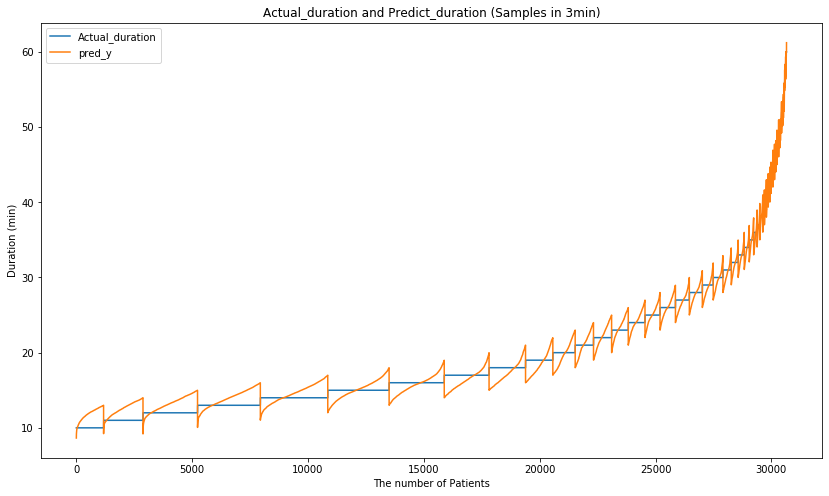

In [231]:
## plot_data['mae'] = np.abs(plot_data.Actual_duration - plot_data.pred_y)
print(f'plot_data {plot_data.shape}')
plot_data_ = plot_data[plot_data.mae <= 3]
print(f'plot_data {plot_data_.shape}')
print(f'precent {plot_data_.shape[0] / plot_data.shape[0]}')
plot_data_.sort_values(by = ['Actual_duration', 'pred_y'], inplace = True)

fig = plt.figure(figsize = (14, 8))
ax = plt.subplot(111)
x = range(plot_data_.shape[0])
y1 = plot_data_.Actual_duration.tolist()
y2 = plot_data_.Scheduled_duration.tolist()
y3 = plot_data_.pred_y.tolist()
ax.plot(x, y1, label = 'Actual_duration')
# ax.plot(x, y2, label = 'Scheduled_duration')
ax.plot(x, y3, label = 'pred_y')
ax.set_xlabel('The number of Patients')
ax.set_ylabel('Duration (min)')
ax.set_title('Actual_duration and Predict_duration (Samples in 3min)')
ax.legend()
plt.show()